In [1]:
# import pandas as pd
# import numpy as np
# import lightgbm as lgb
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import make_scorer
# warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("demand_forecasting_datasets/train.csv", parse_dates=["date"])
test = pd.read_csv("demand_forecasting_datasets/test.csv", parse_dates=["date"])
sample_sub = pd.read_csv('demand_forecasting_datasets/sample_submission.csv')
df = pd.concat([train, test], sort=False)

df.head()

date_column = "date" 
target_column= "sales"
feature_column_1 = "store"
feature_column_2 = "item"
# date column name must me "date"

# #load dataset
# train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
# test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
# df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
# df.head()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [5]:
df.dtypes


date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object

In [6]:
# date key field column name 
# date column name must me "date"

In [7]:
print("Train set:",train.shape)
print("Test set:",test.shape)

Train set: (913000, 4)
Test set: (45000, 4)


In [8]:
# combining the training and test dataset
# df = train +test

df.shape

(958000, 5)

In [9]:
# using quantile function -transform a numeric input variable to have a different data distribution


df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
store,1.0,1.00,3.00,5.5,8.00,10.00,10.00,10.0
item,1.0,3.00,13.00,25.5,38.00,48.00,50.00,50.0
sales,0.0,16.00,30.00,47.0,70.00,107.00,135.00,231.0
id,0.0,2249.95,11249.75,22499.5,33749.25,42749.05,44549.01,44999.0


In [10]:
df[date_column].min()

Timestamp('2013-01-01 00:00:00')

In [11]:
df[date_column].max()

Timestamp('2018-03-31 00:00:00')

In [12]:
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

# *Percentile meaning: how many of the values are less than the given percentile. Read more about percentiles in our Machine Learning Percentile chapter.

df[target_column].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])
# df["sales"].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [13]:
# to find the number of unique values inthe column

df[feature_column_1].nunique()

10

In [14]:

df[feature_column_2].nunique() 

50

In [15]:
# grouping the store column and finding the count of unique items in each store


df.groupby([feature_column_1])[feature_column_2].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [16]:
# group by 2 coumns and finding sales sum and other parameters like mean median and mode

df.groupby([feature_column_1,feature_column_2]).agg({target_column: ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [17]:
df['month'] = df.date.dt.month

df['day_of_month'] = df.date.dt.day

df['day_of_year'] = df.date.dt.dayofyear 

df['week_of_year'] = df.date.dt.weekofyear

df['day_of_week'] = df.date.dt.dayofweek

df['year'] = df.date.dt.year

df["is_wknd"] = df.date.dt.weekday // 4

df['is_month_start'] = df.date.dt.is_month_start.astype(int)

df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

In [18]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [19]:
# month wise forecast

df.groupby([feature_column_1, feature_column_2, "month"]).agg({target_column: ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [42]:
# random noise function 

def random_noise(dataframe):
    return np.random.normal(scale=10, size=(len(dataframe),))

In [43]:

# sorting according to date

df.sort_values(by=[feature_column_1, feature_column_2, 'date'], axis=0, inplace=True)
df.head()

,date,store,item,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,1,2.639057,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,1,1,2.484907,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,2.708050,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,2.639057,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,1,1,2.397895,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [44]:
# lag features function 


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby([feature_column_1, feature_column_2])[target_column].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [45]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby([feature_column_1, feature_column_2])[target_column]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

In [46]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby([feature_column_1, feature_column_2])[target_column].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,date,store,item,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
44995,2018-03-27,10,50,NaN,44995.0,27,86,13,2018,0,0,0,11.308210,13.311183,10.213176,-7.534884,7.617066,-3.433590,-2.308171,3.272269,26.492340,-3.735420,5.593096,9.524709,18.741465,3.739845,4.007197,4.217410,4.231871,4.418595,4.728207,4.206710,4.577709,4.300585,3.749320,4.007548,4.209502,4.223526,4.417565,4.730890,4.214722,4.550442,4.287616,3.762876,4.009804,4.200699,4.214275,4.416099,4.732874,4.224560,4.520257,4.273523,3.795479,4.019283,4.186663,4.198840,4.412386,4.732077,4.243306,4.472267,4.252169,3.834882,4.033902,4.177237,4.186505,4.407916,4.724846,4.259983,4.439488,4.239319,3.929054,4.073956,4.170442,4.171228,4.401651,4.693676,4.282102,4.411394,4.233500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,28,87,13,2018,0,0,0,11.478750,-1.973929,3.315768,3.922079,14.372905,1.321892,7.155139,8.981851,6.341801,14.301030,15.780981,5.113942,1.633590,4.154693,3.951803,4.219487,4.112084,4.509937,4.786899,4.111832,4.396282,4.234771,4.138405,3.954059,4.219007,4.116506,4.506195,4.784662,4.116066,4.402249,4.236782,4.119282,3.957100,4.217627,4.121214,4.501383,4.782030,4.122243,4.407030,4.238048,4.086202,3.964852,4.212939,4.128467,4.491165,4.776409,4.137360,4.410013,4.237719,4.061683,3.976041,4.206827,4.133563,4.479976,4.768698,4.155607,4.407961,4.235670,4.043968,4.012600,4.194975,4.141051,4.456255,4.740584,4.196488,4.402922,4.233803,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,29,88,13,2018,0,0,0,9.664837,-14.294735,6.071261,-1.858757,10.544116,15.081284,6.780609,13.012753,14.500519,1.003717,8.577860,4.789240,-5.306496,4.094948,4.156812,4.289750,4.203767,4.643046,4.795702,4.302143,4.603081,4.329774,4.096548,4.148642,4.286887,4.200283,4.637481,4.795234,4.294665,4.595024,4.326036,4.096838,4.138705,4.283176,4.196345,4.630090,4.794414,4.285883,4.585356,4.321465,4.092716,4.120077,4.274955,4.189448,4.613746,4.791914,4.270724,4.566139,4.312130,4.084546,4.104031,4.265370,4.183354,4.595067,4.787663,4.259528,4.546007,4.302214,4.069156,4.085742,4.242717,4.172872,4.550323,

In [47]:


df = pd.get_dummies(df, columns=['day_of_week', 'month'])

KeyError: "None of [Index(['day_of_week', 'month'], dtype='object')] are in the [columns]"

In [ ]:
# [feature_column_1, feature_column_2])[target_column

df[target_column] = np.log1p(df[target_column].values)

In [ ]:

train = df.loc[(df[date_column] < "2017-01-01"), :]


val = df.loc[(df[date_column] >= "2017-01-01") & (df[date_column] < "2017-04-01"), :]


cols = [col for col in train.columns if col not in [date_column, 'id', target_column, "year"]]

In [ ]:

Y_train = train[target_column]


X_train = train[cols]


Y_val = val[target_column]


X_val = val[cols] 


Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)


smape(np.expm1(y_pred_val), np.expm1(Y_val))

In [32]:
#Final Model



train = df.loc[~df.sales.isna()]
Y_train = train[target_column]
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [33]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207121 seconds.
You can set `force_col_wise=true` to remove the overhead.


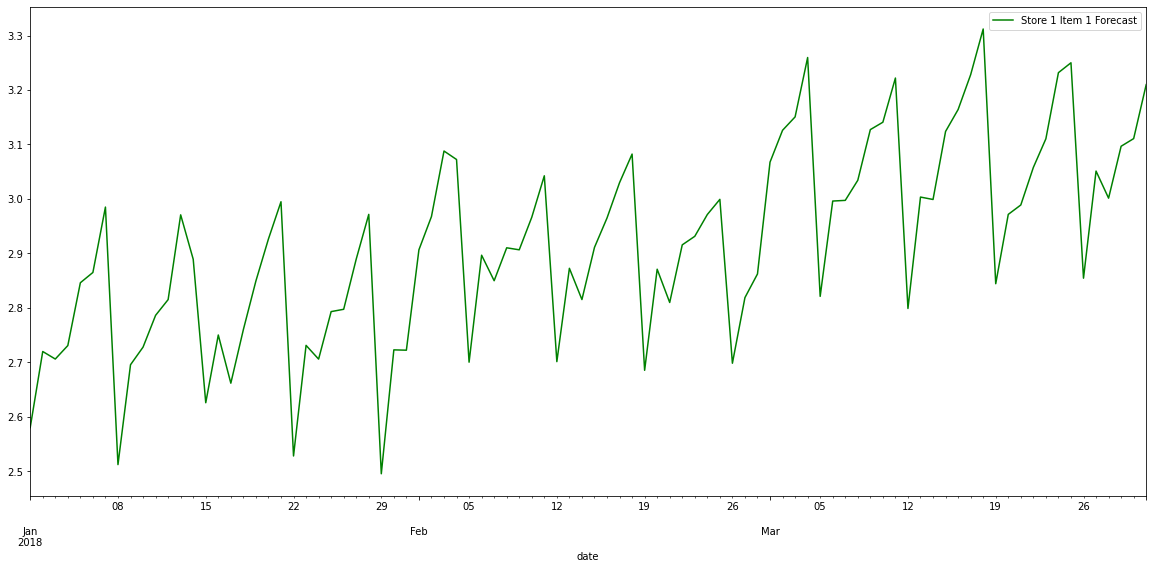

In [34]:
# [feature_column_1, feature_column_2])[target_column

forecast = pd.DataFrame({date_column:test[date_column],
                        feature_column_1:test[feature_column_1],
                        feature_column_2:test[feature_column_2],
                        target_column:test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index(date_column).sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

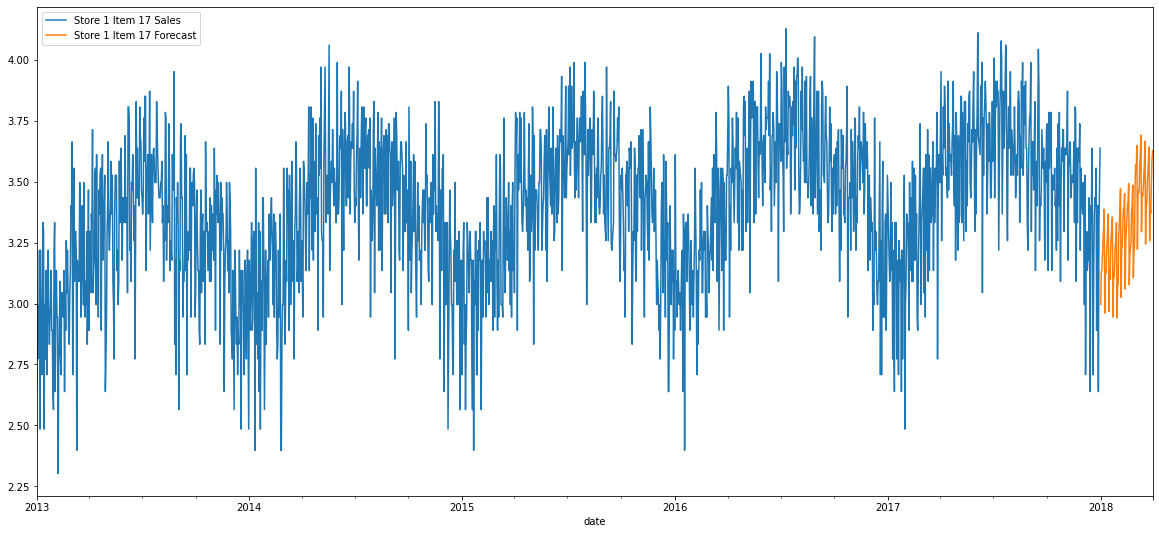

In [35]:


train[(train.store == 1) & (train.item == 17)].set_index(date_column).sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index(date_column).sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

In [36]:
df.shape

(958000, 98)

In [39]:
forecast.sales.max()

4.993262109740535

In [41]:
forecast


,date,store,item,sales
0,2018-01-01,1,1,2.580237
1,2018-01-02,1,1,2.719939
2,2018-01-03,1,1,2.706102
3,2018-01-04,1,1,2.730826
4,2018-01-05,1,1,2.846149
...,...,...,...,...
44995,2018-03-27,10,50,4.290205
44996,2018-03-28,10,50,4.329036
44997,2018-03-29,10,50,4.383560
44998,2018-03-30,10,50,4.452298
